In [1]:
#Import relevant libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools

# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lager-coboh-20212022-jcdep/Lager_CO-Boh_enjeu-pH_sep2022.csv


# Exploration of pH variations in lagers brewed with two strains from Labo Solution yeasts
---
## Dataset :
Beers brewed from 2 different locations, with 2 different types of lager yeast strains. Data consists of post-boil pH (pre-yeast), post-pitch pH (post-yeast addition) and final pH witouth any dry-hopping :
<div class="alert alert-block alert-info">
<b>Fact: </b> We use pre dry-hopping (DH) pH because cold addition of hops is known to increase the pH of the beer. It will be then irrelevant to compare beers that have a different cold-hopping regime : 
<ul> 
    <li><a href="http://www2.uwstout.edu/content/lib/thesis/2014/2014schmickm.pdf">Dry Hopping and its Effect on Beer pH (Shmick 2014)</a></li>
    <li><a href="https://www.hopsteiner.com/wp-content/uploads/2016/06/2016-05_TS_PH.pdf">Hopsteiner Technical Newsletter</a></li>
    <li><a href="http://scottjanish.com/a-look-at-ph-in-hoppy-beers/">A look at pH in hoppy beers (Janish 2020 blog post)</a></li>
</ul>
</div>

## Data collection :
pH readings taken at 15-25 C with ThermoFisher Orion A111 or Hanna Edge pH meter. Gravity readings with either traditional hydrometer or EasyDens (Anton Paar)

## Data types : 
Categorical, numerical and transformed/computed.

---

In [2]:
# Import data and set proper header for dataframe
df = pd.read_csv("../input/lager-coboh-20212022-jcdep/Lager_CO-Boh_enjeu-pH_sep2022.csv",header=4)

# Lookup median for diff pitch and diff total to help later set categorical var
df.median(axis=0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


FV                           5.000
# brassin                  717.000
Gen                          1.000
Post-Boil pH                 5.330
Post-pitch pH (FV)           5.045
Final (pre-DH)               4.360
diff pitch pH               -0.170
diff Total pH               -1.005
Specialty Torref. malts      0.000
OG (P)                      11.900
dtype: float64

## Transform diff-pitch (Post-boil pH - post-pitch pH) into categorical data
**Labels :**
- |diff pitch pH| >= 0.2 = big_shift_pitch
- |diff pitch pH| < 0.2 = small_shift_pitch

In [3]:
def label_diff_pitch (row):
    if row['diff pitch pH'] <= -0.2 :
        return 'big_shift_pitch'
    if row['diff pitch pH'] > -0.2 :
        return 'small_shift_pitch'
    else :
        return 'NA'
# Check for proper function behavior
lab_diffpitch = df.apply(lambda row: label_diff_pitch(row), axis=1)
# Apply to df and create column
df.insert(12, "label_diff_pitch", lab_diffpitch)


## Transform diff total pH (Post-boil pH - final pH) into categorical data
**Labels :**
- |diff tot pH| >= 1 = big_shift_tot
- |diff tot pH| < 1 = small_shift_tot

In [4]:
def label_diff_tot (row):
    if row['diff Total pH'] <= -1 :
        return 'big_shift_tot'
    if row['diff Total pH'] > -1 :
        return 'small_shift_tot'
    else :
        return 'NA'
# Check for proper function behavior
lab_difftot = df.apply(lambda row: label_diff_tot(row), axis=1)
# Apply to df and create column
df.insert(14, "label_diff_tot", lab_difftot)

# Basic categorical feature visualization
- Whole Dataframe
- brews per site
- styles brewed
- generations
- yeast type

In [5]:
# View whole dataframe
df

,Lieu,Date brassin,FV,Bière,# brassin,Levure,Gen,Tag,Post-Boil pH,Post-pitch pH (FV),Final (pre-DH),diff pitch pH,label_diff_pitch,diff Total pH,label_diff_tot,# lot levure,Specialty Torref. malts,OG (P)
0,Dépôt,2022-09-14,8,TMB,1750,Boh,0,Dépôt-TMB-1750-Boh-0,5.26,5.12,4.23,-0.14,small_shift_pitch,-1.03,big_shift_tot,NaN,False,11.9
1,Dépôt,2022-08-24,9,Gil,1740,Boh,0,Dépôt-Gil-1740-Boh-0,5.09,4.99,4.41,-0.10,small_shift_pitch,-0.68,small_shift_tot,22529,True,17.4
2,Dépôt,2022-08-24,8,VA,1739,Boh,0,Dépôt-VA-1739-Boh-0,5.42,5.25,4.36,-0.17,small_shift_pitch,-1.06,big_shift_tot,22529,True,11.2
3,Dépôt,2022-07-27,8,TMB,1721,Boh,0,Dépôt-TMB-1721-Boh-0,5.48,5.41,4.64,-0.07,small_shift_pitch,-0.84,small_shift_tot,22219,False,11.9
4,Dépôt,2022-06-09,9,She,1694,Boh,0,Dépôt-She-1694-Boh-0,5.33,5.17,3.97,-0.16,small_shift_pitch,-1.36,big_shift_tot,22219,False,11.9
5,Dépôt,2022-07-29,9,Lei,1723,Boh,2,Dépôt-Lei-1723-Boh-2,5.32,5.22,4.52,-0.10,small_shift_pitch,-0.80,small_shift_tot,sib1703,False,8.6
6,Dépôt,2022-06-30,9,TMB,1707,Boh,1,Dépôt-TMB-1707-Boh-1,5.35,5.25,4.63,-0.10,small_shift_pitch,-0.72,small_shift_tot,sib1674,False,10.7
7,Dépôt,2022-06-28,8,Vie,1703,Boh,1,Dépôt-Vie-1703-Boh-1,4.86,NaN,4.57,NaN,NA,-0.29,small_shift_tot,sib1694,True,10.6
8,Dépôt,2022-05-17,9,TMB,1675,Boh,1,Dépôt-TMB-1675-Boh-1,5.31,5.29,4.74,-0.02,small_shift_pitch,-0.57,small_shift_tot,sib1653,False,11.3
9,Dépôt,2022-04-06,9,TMB,1653,Boh,0,Dépôt-TMB-1653-Boh-0,5.37,5.33,4.45,-0.04,small_shift_pitch,-0.92,small_shift_tot,22046,False,12.4


**Almost even distribution of number of batches brewed per site, but...***

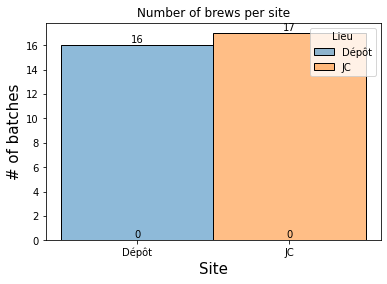

In [6]:
# Batches per site
p_site = sns.histplot(data=df, x="Lieu", hue="Lieu")
p_site.set(title = "Number of brews per site")
p_site.set_xlabel("Site", fontsize = 15)
p_site.set_ylabel("# of batches", fontsize= 15)
# label each bar in histogram
for p in p_site.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 p_site.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center



**As we can see, most of the lagers brewed at JC are Sherbiere, at least in this dataset/time period**

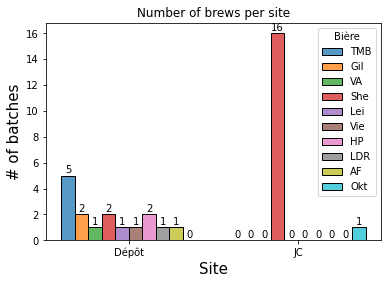

In [7]:
# Batches per site with SKUs
p_sitesku = sns.histplot(data=df, x="Lieu", hue="Bière",shrink=0.8, multiple="dodge")
p_sitesku.set(title = "Number of brews per site")
p_sitesku.set_xlabel("Site", fontsize = 15)
p_sitesku.set_ylabel("# of batches", fontsize= 15)
# label each bar in histogram
for p in p_sitesku.patches:
 height = p.get_height() # get the height of each bar
 # adding text to each bar
 p_sitesku.text(x = p.get_x()+(p.get_width()/2), # x-coordinate position of data label, padded to be in the middle of the bar
 y = height+0.2, # y-coordinate position of data label, padded 0.2 above bar
 s = '{:.0f}'.format(height), # data label, formatted to ignore decimals
 ha = 'center') # sets horizontal alignment (ha) to center

**Different representation of generations of yeast for SKUs**

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1296: UserWarning: 5.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


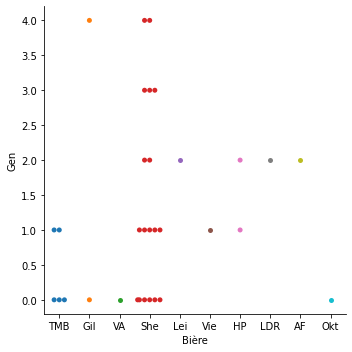

In [8]:
# Generations per SKU types
p_gensku = sns.catplot(data=df, x="Bière",y="Gen", kind="swarm", hue="Bière")

**LCO yeast seems more widely distribued than accros generations than Boh**

<AxesSubplot:xlabel='Levure', ylabel='Gen'>

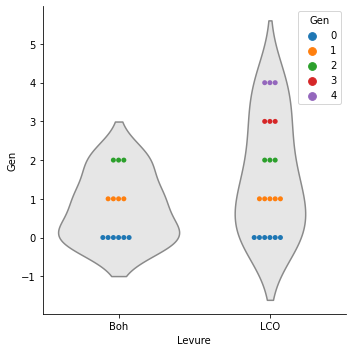

In [9]:
p_genyeast  = sns.catplot(data=df, x="Levure",y="Gen", kind="violin", dodge=True, inner=None, color=".9")
sns.swarmplot(data=df,x="Levure",y="Gen", size=5, hue="Gen")

## pH distributions for different timepoints

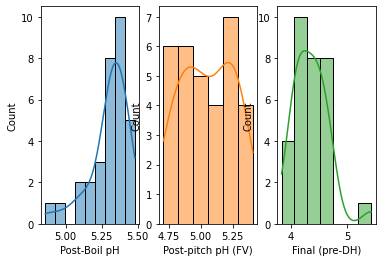

In [10]:
pH_tp = ["Post-Boil pH", "Post-pitch pH (FV)","Final (pre-DH)"]
fig, axes = plt.subplots(1,3)
ncols = len(pH_tp)
palette = itertools.cycle(sns.color_palette())

for i,t in enumerate(pH_tp):
    sns.histplot(data=df, x=t, ax=axes[i % ncols],color=next(palette),kde=True)

In [11]:
# Test of normality for all pH distributions

